# 📚 Diamonds 데이터 분석 캡스톤

In [2]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, concat, pivot_table, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from math import sqrt


# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova, pairwise_tukey, pairwise_gameshowell

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator

# 파이썬 기본 패키지
from itertools import combinations

In [3]:
origin = load_data("diamonds")
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)


===== 데이터 크기 확인 =====
데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


## 과제 1. 이 데이터는 얼마나 믿을 수 있을까?

In [4]:
origin.describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00


#### x(길이),y(높이),z(깊이) 에서 0으로 보이는 값들이 존재 한다.

#### 비어 있는 값이 있는가?(결측치)

In [5]:
df = origin.copy()
df.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

#### 결측치는 존재하지 않는 것으로 보인다.

In [6]:
for i in ["cut", "color", "clarity"]:
    print(df[i].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


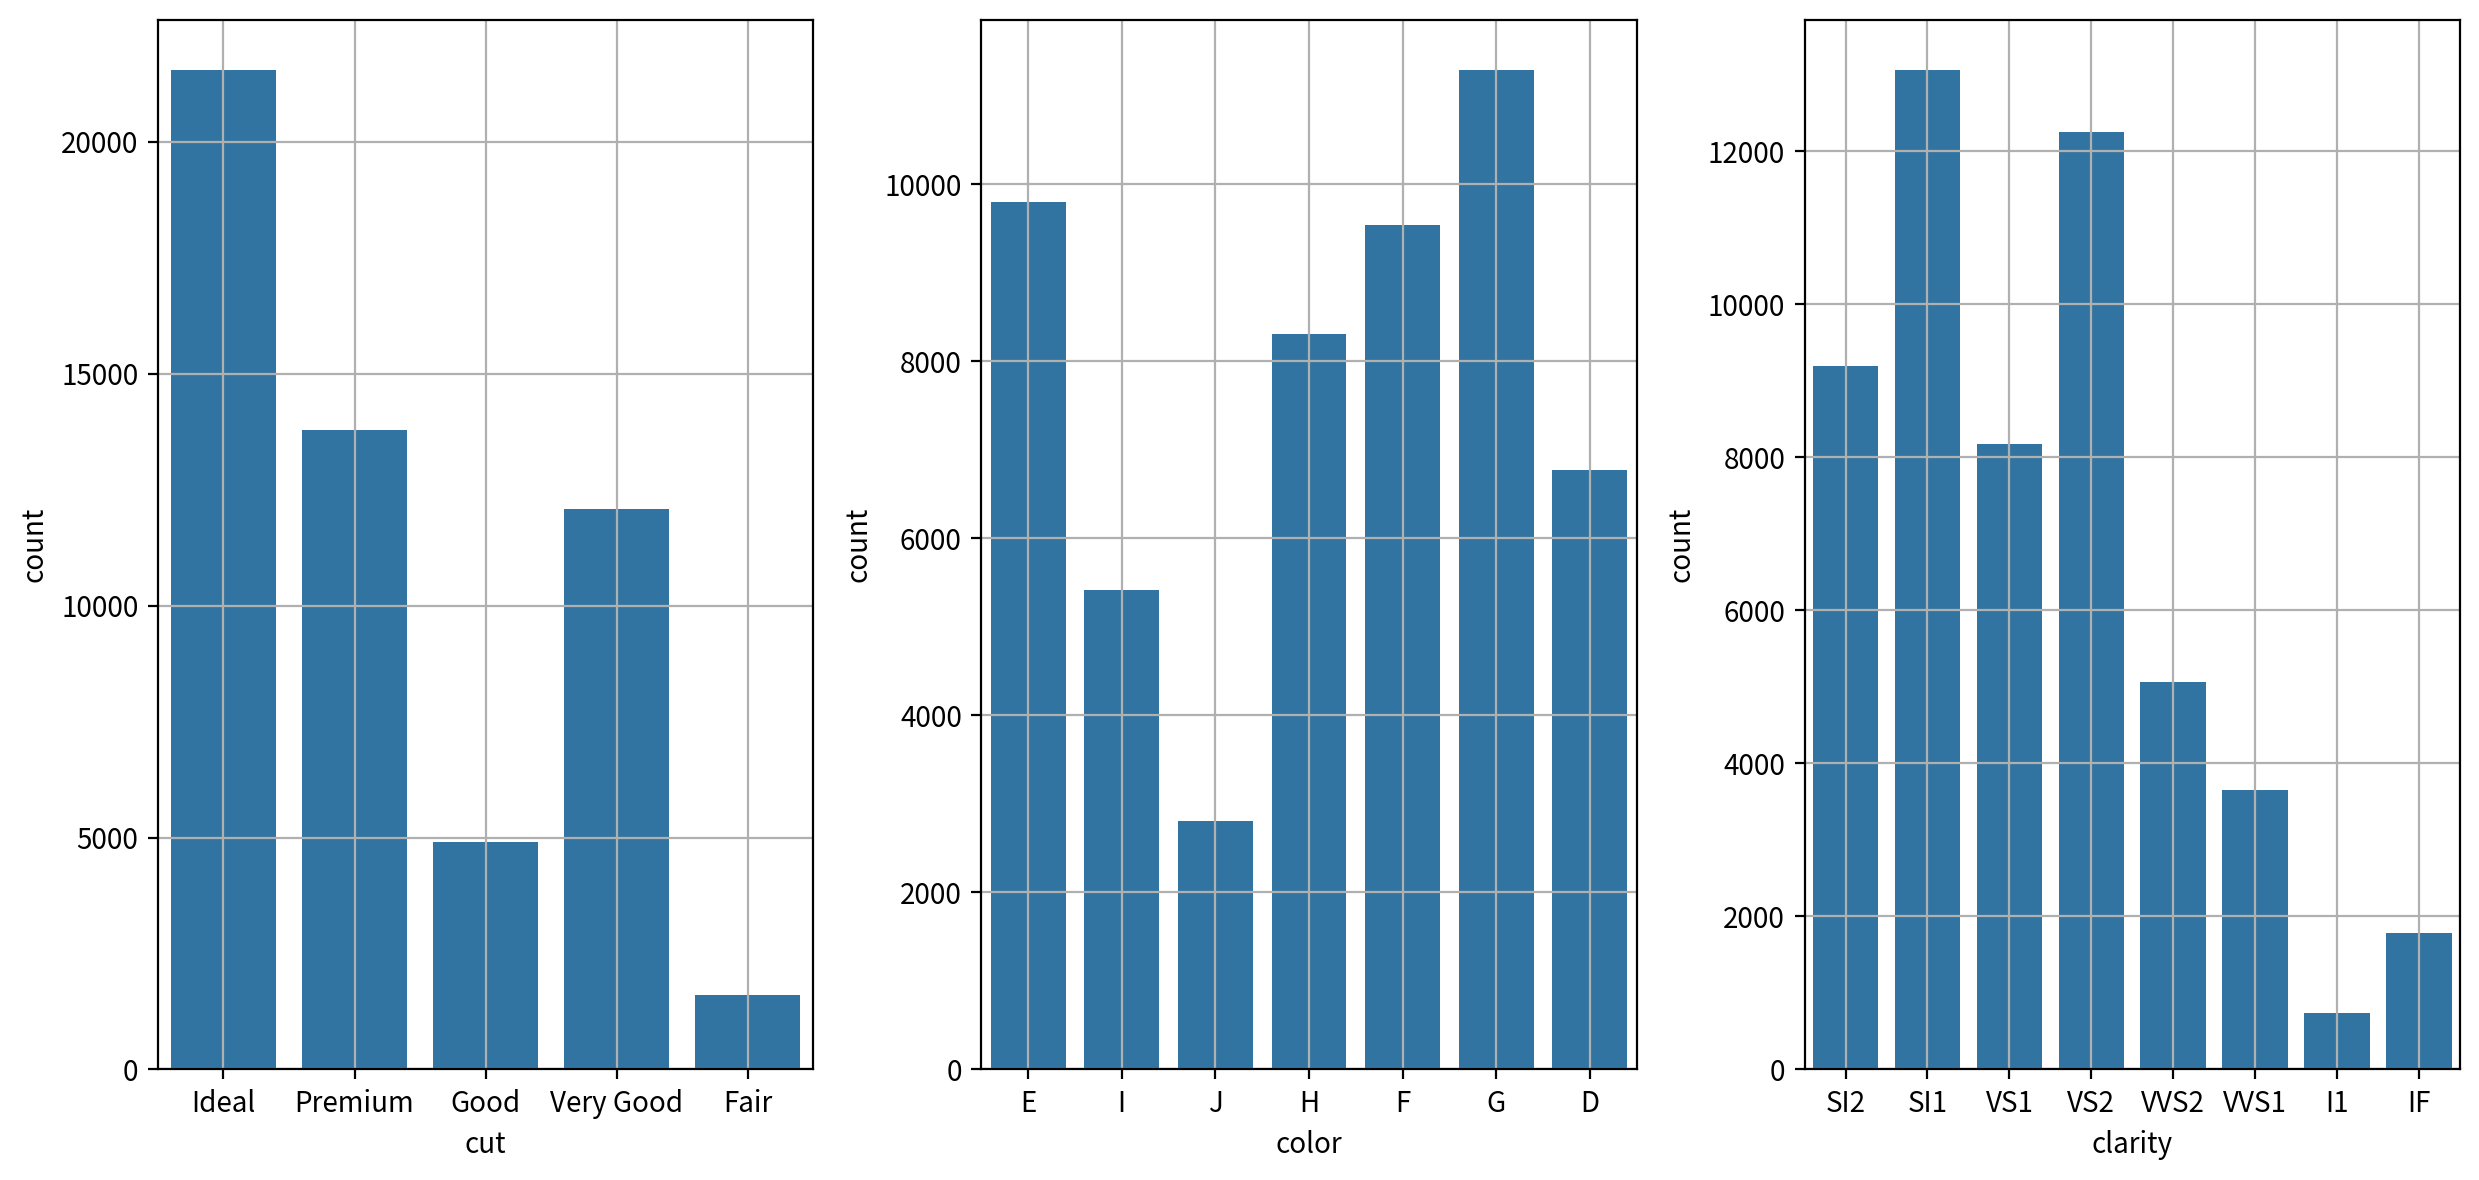

In [7]:
data = ["cut", "color", "clarity"]

# 1) 그래프 초기화 (밖에서 한 번만)
rows = 1
cols = len(data)
width_px = 2500
height_px = 1200
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.countplot(data=df, x=v, ax=ax[i])
    ax[i].grid(True)

plt.tight_layout()
plt.show()
plt.close()

cut: Ideal 범주의 빈도가 가장 많고, Fair가 가장 적다.

color: G 범주의 빈도가 가장 많고, J가 가장 적다.

clarity: I1 범주의 빈도가 가장 적으며, 상대적으로 SI1, VS2 등의 범주에 데이터가 많이 분포한다.



In [8]:
xyz = ["x", "y", "z"]
((df[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(20)

In [9]:
xyz = ["x", "y", "z"]
((df[xyz] < 0).sum(axis=1) > 0).sum()

np.int64(0)

x,y,z 에 관하여 0인 값들이 20개 존재하는 것으로 보여지며 0 이하의 값들은 존재 하지 않는다
다이아몬드는 물리적 실체를 가지므로 길이(x), 너비(y), 깊이(z) 중 하나라도 0인 값은 현실적으로 불가능한 기록(측정 오류)로 판단하였다. 따라서 x, y, z 중 하나라도 0인 관측치는 제거한 후 분석을 진행하였다.

In [10]:
xyz = ["x", "y", "z"]
df1 = df[(df[xyz] != 0).all(axis=1)]
df1

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


In [11]:
((df1[xyz] == 0).sum(axis=1) > 0).sum()

np.int64(0)

## 미션 2. “가격 데이터는 어떤 모습일까?”

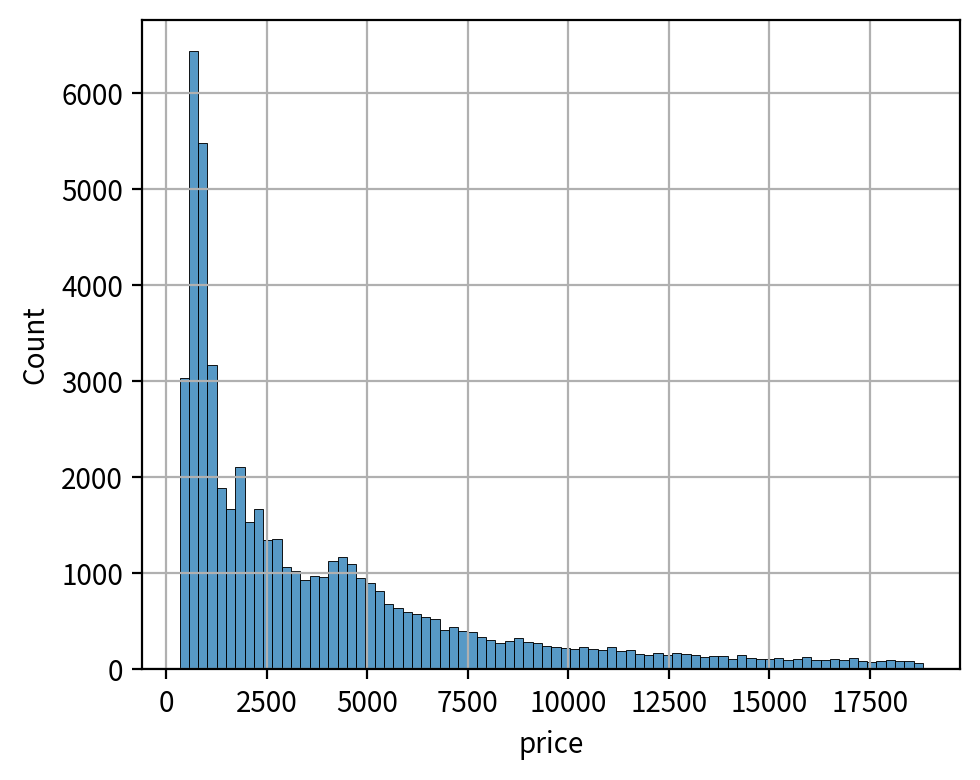

In [12]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df1, x="price")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

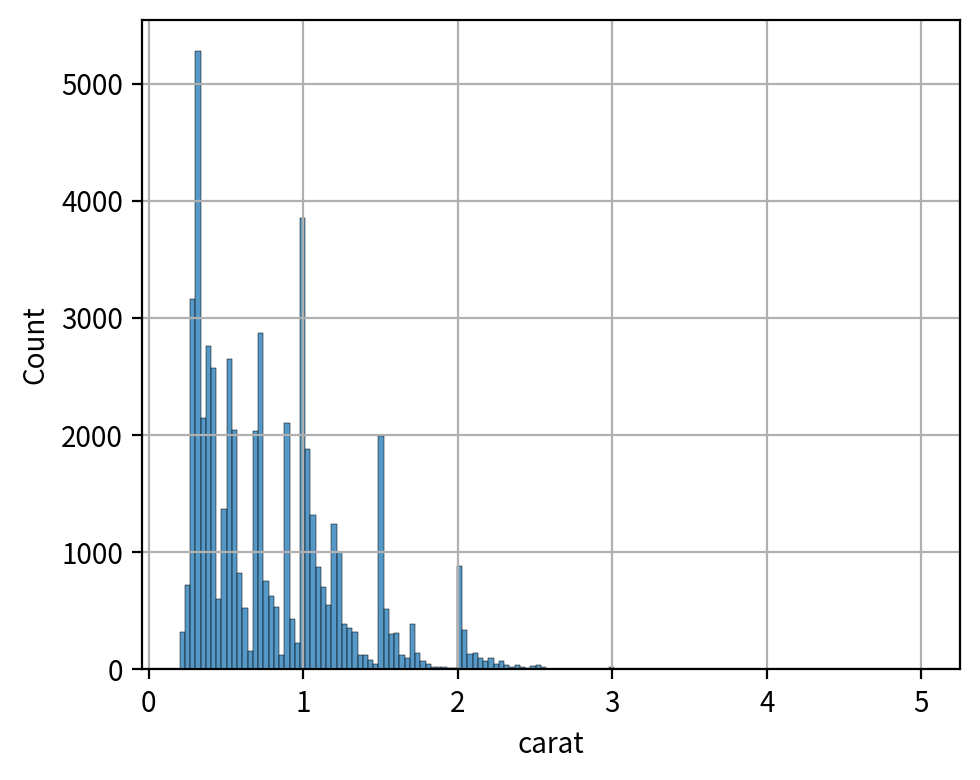

In [13]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df1, x="carat")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

price와 carat의 분포를 확인한 결과, 두 변수 모두 낮은 값에 데이터가 몰려 있고 높은 값 방향으로 꼬리가 길게 나타났다. 이런 형태는 정규분포와는 거리가 있어 보이므로, 그대로 회귀분석을 진행하면 잔차도 한쪽으로 치우쳐 해석이 어려울 수 있다. 따라서 회귀를 바로 진행하기보다는 로그 변환처럼 분포를 완화하는 방법을 검토할 필요가 있다.

## 미션 3. “로그 변환은 왜 등장할까?”

In [14]:
df2 = df1.copy()
df2["log_price"] = np.log(df2["price"])
df2["log_carat"] = np.log(df2["carat"])
df2.head()

,price,carat,cut,color,clarity,x,y,z,depth,table,log_price,log_carat
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0,5.786897,-1.469676
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0,5.786897,-1.560648
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0,5.789960,-1.469676
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0,5.811141,-1.237874
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0,5.814131,-1.171183


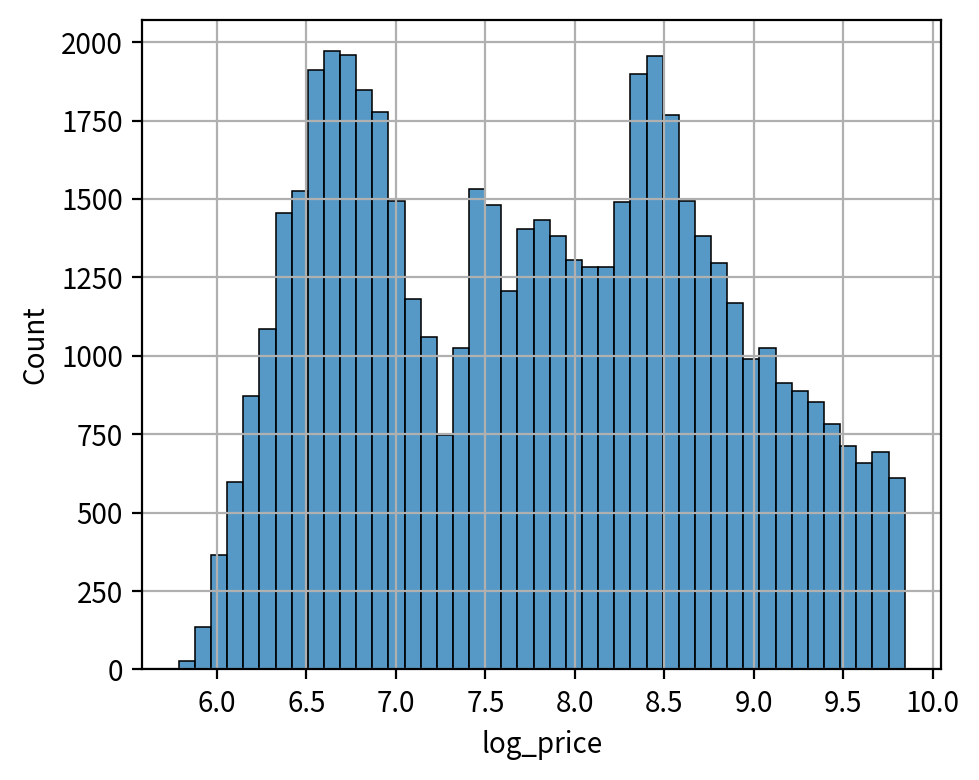

In [15]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df2, x="log_price")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

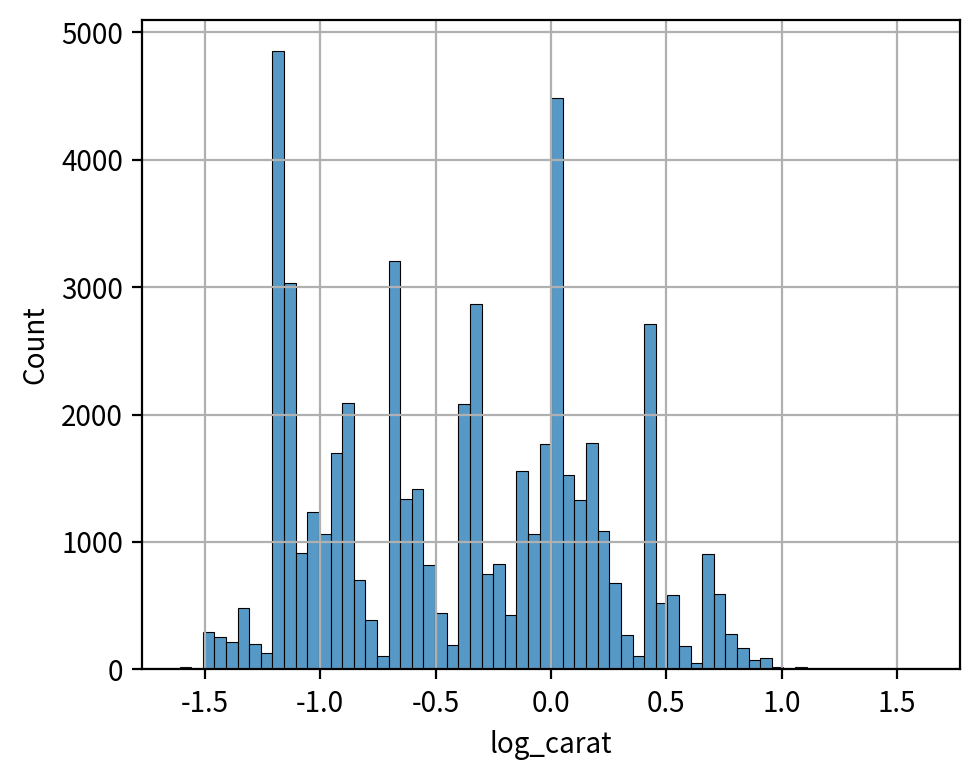

In [16]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
sb.histplot(data=df2, x="log_carat")

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

가격과 carat에 로그 변환을 한 결과 큰 값은 눌러서 작아지고, 작은 값은 상대적으로 덜 변해서 전체 분포가 더 균형 있게 보이게 된다.  
로그 변환 후 히스토그램을 보면 변환 전보다 오른쪽으로 길게 늘어진 꼬리가 줄어든 느낌이 있다. 즉, 극단적으로 큰 값의 영향이 줄었다고 볼 수 있다.  
다만 정규성 검정을 하면 p-value가 0에 가까워서 정규성은 충족 되지 않는다  
즉 로그 변환은 정규분포를 완벽하게 만들기보다는 치우친 분포를 덜 치우치게 만들고 극단값을 줄여서 이후 회귀분석을 더 안정적으로 하기 위해 사용한다.  

## 미션 4. “품질 등급은 가격을 얼마나 설명해 줄까?

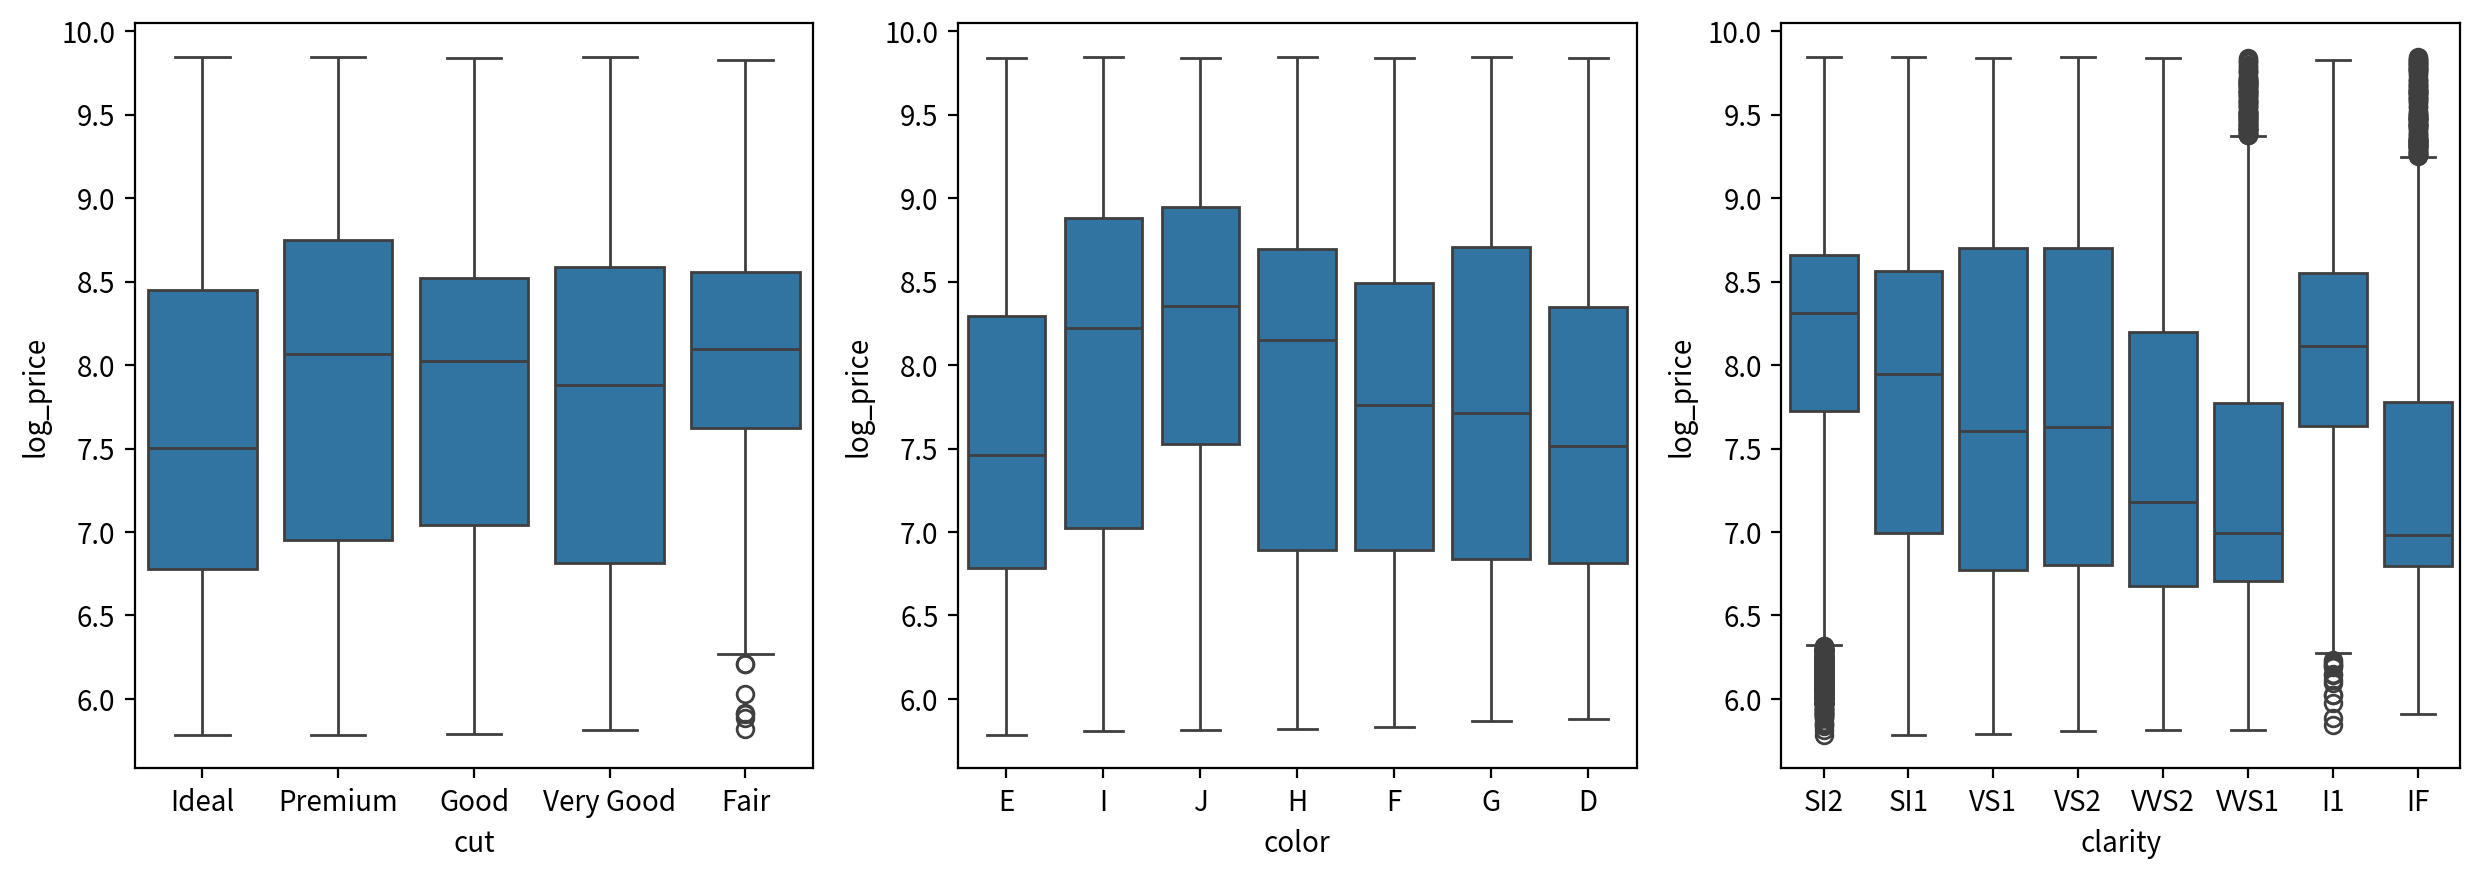

In [17]:
data = ["cut", "color", "clarity"]


# 1) 그래프 초기화
rows = 1
cols = len(data)
width_px = 2500
height_px = 900
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(data):
    sb.boxplot(data=df2, x=v, y="log_price", ax=ax[i])

plt.tight_layout()
plt.show()
plt.close()

cut 기준으로는 Premium의 중앙값이 상대적으로 높고, 박스 폭도 넓어 가격 변동(분산)이 큰 편으로 보인다. Fair는 박스 폭은 비교적 좁지만 이상치가 관찰되어 일부 극단값이 존재함을 확인할 수 있다.

color는 등급 간 가격 분포가 많이 겹쳐, 색상 등급만으로 가격을 뚜렷하게 구분하기 어렵다.

clarity 역시 분포 겹침이 존재해 단독으로 가격을 완전히 가르긴 어렵지만, 세 품질 변수 중에서는 등급별 중앙값 차이가 상대적으로 더 뚜렷하게 나타나 가격 차이를 가장 잘 보여주는 변수로 관찰된다.

결론적으로, 가격 차이가 비교적 뚜렷한 품질 변수는 clarity이고, color는 등급 간 분포 겹침이 커 등급이 달라도 비슷한 가격 구간이 많이 나타난다.

## 미션 5. “Premium 컷은 정말 더 비쌀까?

독립성 t-test를 사용하여 서로 다른 두개의 그룹 간 평균의 차이가 유의미한지 여부를 판단한다.

cut에서 Premium이랑 Ideal등급인 가격정보만 따로 가져온다

In [18]:
df3 = (
    df2.query("cut == 'Premium' or cut == 'Ideal'")[["cut", "log_price"]]
    .dropna()
    .copy()
)

premium = df3.loc[df3["cut"] == "Premium", "log_price"].reset_index(drop=True)
ideal = df3.loc[df3["cut"] == "Ideal", "log_price"].reset_index(drop=True)

df4 = concat([premium, ideal], axis=1)
df4.columns = ["Premium", "Ideal"]
df4

,Premium,Ideal
0,5.786897,5.786897
1,5.811141,5.828946
2,5.834811,5.840642
3,5.843544,5.852202
4,5.843544,5.998937
...,...,...
21543,NaN,7.921536
21544,NaN,7.921536
21545,NaN,7.921536
21546,NaN,7.921898


각각의 인덱스를 초기화 후 하나의 행으로 합쳤다

In [19]:
data = df4[["Premium", "Ideal"]]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    x = data[c].dropna()  # 결측치 제거

    s, p = normaltest(x)
    normalize = p > 0.05

    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})

    normal_dist = normal_dist and normalize
    equal_var_fields.append(x)

# 정규성 결과에 따라 등분산 검정 선택
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
Premium,9971.943330,0.000000e+00,False
Ideal,4631.300567,0.000000e+00,False
Levene,72.949864,1.382238e-17,False


Premium과 Ideal의 log_price에 대해 정규성 검정을 수행한 결과 두 그룹 모두 p-value≈0으로 정규성 가정이 충족되지 않았고, Levene 검정에서도 p<0.05 이므로 등분산 가정이 위배되었다.
따라서 등분산 가정 없이 평균 차이를 비교할 수 있는 Welch t-test를 적용한다.

In [20]:
s, p = ttest_ind(
    df4["Premium"].dropna(),
    df4["Ideal"].dropna(),
    equal_var=False,
    alternative="greater",
)

result = "statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(
    s, p, "대립" if p <= 0.05 else "귀무"
)
print(result)

statistic: 28.053, p-value: 0.000, 대립가설 채택


p = 3.79e-171로 (p<0.05) 귀무가설을 기각하였다. 따라서 Premium의 평균(log_price)은 Ideal보다 통계적으로 유의하게 더 크다

## 📝미션 6. “모든 컷은 서로 다를까?”

In [21]:
df6 = df2[["cut", "log_price"]].dropna().copy()
df6

,cut,log_price
0,Ideal,5.786897
1,Premium,5.786897
2,Good,5.789960
3,Premium,5.811141
4,Good,5.814131
...,...,...
53935,Ideal,7.921898
53936,Good,7.921898
53937,Very Good,7.921898
53938,Premium,7.921898


In [22]:
field = "log_price"
hue_field = "cut"

df = df6[[field, hue_field]].copy()
df["idx"] = df.groupby(hue_field).cumcount()

data = pivot_table(df, index="idx", columns=hue_field, values=field, aggfunc="first")


normal_dist = True
report = []
values = []

for c in data.columns:
    target = data[c].dropna()
    values.append(target)

    s, p = normaltest(target)
    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산성
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*values)
else:
    n = "Levene"
    s, p = levene(*values, center="median")

equal_var = p > 0.05
report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
Fair,5.576223,6.153730e-02,True
Good,709.824985,7.302353e-155,False
Ideal,4631.300567,0.000000e+00,False
Premium,9971.943330,0.000000e+00,False
Very Good,4704.114948,0.000000e+00,False
Levene,122.580235,2.492832e-104,False


cut별 log_price 분포에 대해 가정 검정을 수행한 결과, 대부분의 컷은 정규성이 충족되지 않았고, Levene 검정에서도 p=2.49e-104로 등분산성이 명확히 위배되었다.
따라서 등분산을 전제로 하는 일반 일원분산분석보다는, 등분산 가정 없이 컷 간 평균 차이를 검정할 수 있는 방법을 적용하는 것이 타당하다.

In [23]:
anova_df = df6[[field, hue_field]]

if equal_var:
    pg_anova = anova(data=anova_df, dv=field, between=hue_field)
else:
    pg_anova = welch_anova(data=anova_df, dv=field, between=hue_field)

display(pg_anova)

f_val = pg_anova["F"].iloc[0]
p_val = pg_anova["p-unc"].iloc[0]
print(
    "statistic: {0:.3f}, p-value: {1:.3g}, {2}가설 채택".format(
        f_val, p_val, "대립" if p_val <= 0.05 else "귀무"
    )
)

if equal_var:
    print("== Tukey HSD ==")
    hoc_df = pairwise_tukey(data=anova_df, dv=field, between=hue_field)
else:
    print("== Games-Howell ==")
    hoc_df = pairwise_gameshowell(anova_df, dv=field, between=hue_field)

display(hoc_df)

,Source,ddof1,ddof2,F,p-unc,np2
0,cut,4,9549.209014,273.943147,2.744201e-223,0.018082


statistic: 273.943, p-value: 2.74e-223, 대립가설 채택
== Games-Howell ==


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499


Welch ANOVA 결과, cut에 따라 log_price 평균은 유의하게 달라 귀무가설을 기각하였다(p = 2.74e-223). 즉, 컷 등급에 따른 가격 차이가 전반적으로 존재함이 통계적으로 확인되었다.
평균(log_price)은 Fair(8.093) > Premium(7.950) > Good(7.842) > Very Good(7.799) > Ideal(7.639) 순으로 나타났다.
사후검정에서는 Good–Very Good만 유의한 차이가 없었으며(p=0.072), 그 외 모든 조합은 유의했다. 따라서 유의성까지 반영한 서열은 Fair > Premium > Good ≈ Very Good > Ideal로 정리된다.

## 📝미션 7. “품질 요인들은 서로 영향을 주고받을까?”

원할한 분석을 위하여 각각의 값만 따로 데이터프레임을 뽑아 분석하기 쉽게 전처리 해주었다.

In [24]:
df7 = df2[["cut", "color", "log_price"]].copy()
df7

,cut,color,log_price
0,Ideal,E,5.786897
1,Premium,E,5.786897
2,Good,E,5.789960
3,Premium,I,5.811141
4,Good,J,5.814131
...,...,...,...
53935,Ideal,D,7.921898
53936,Good,D,7.921898
53937,Very Good,D,7.921898
53938,Premium,H,7.921898


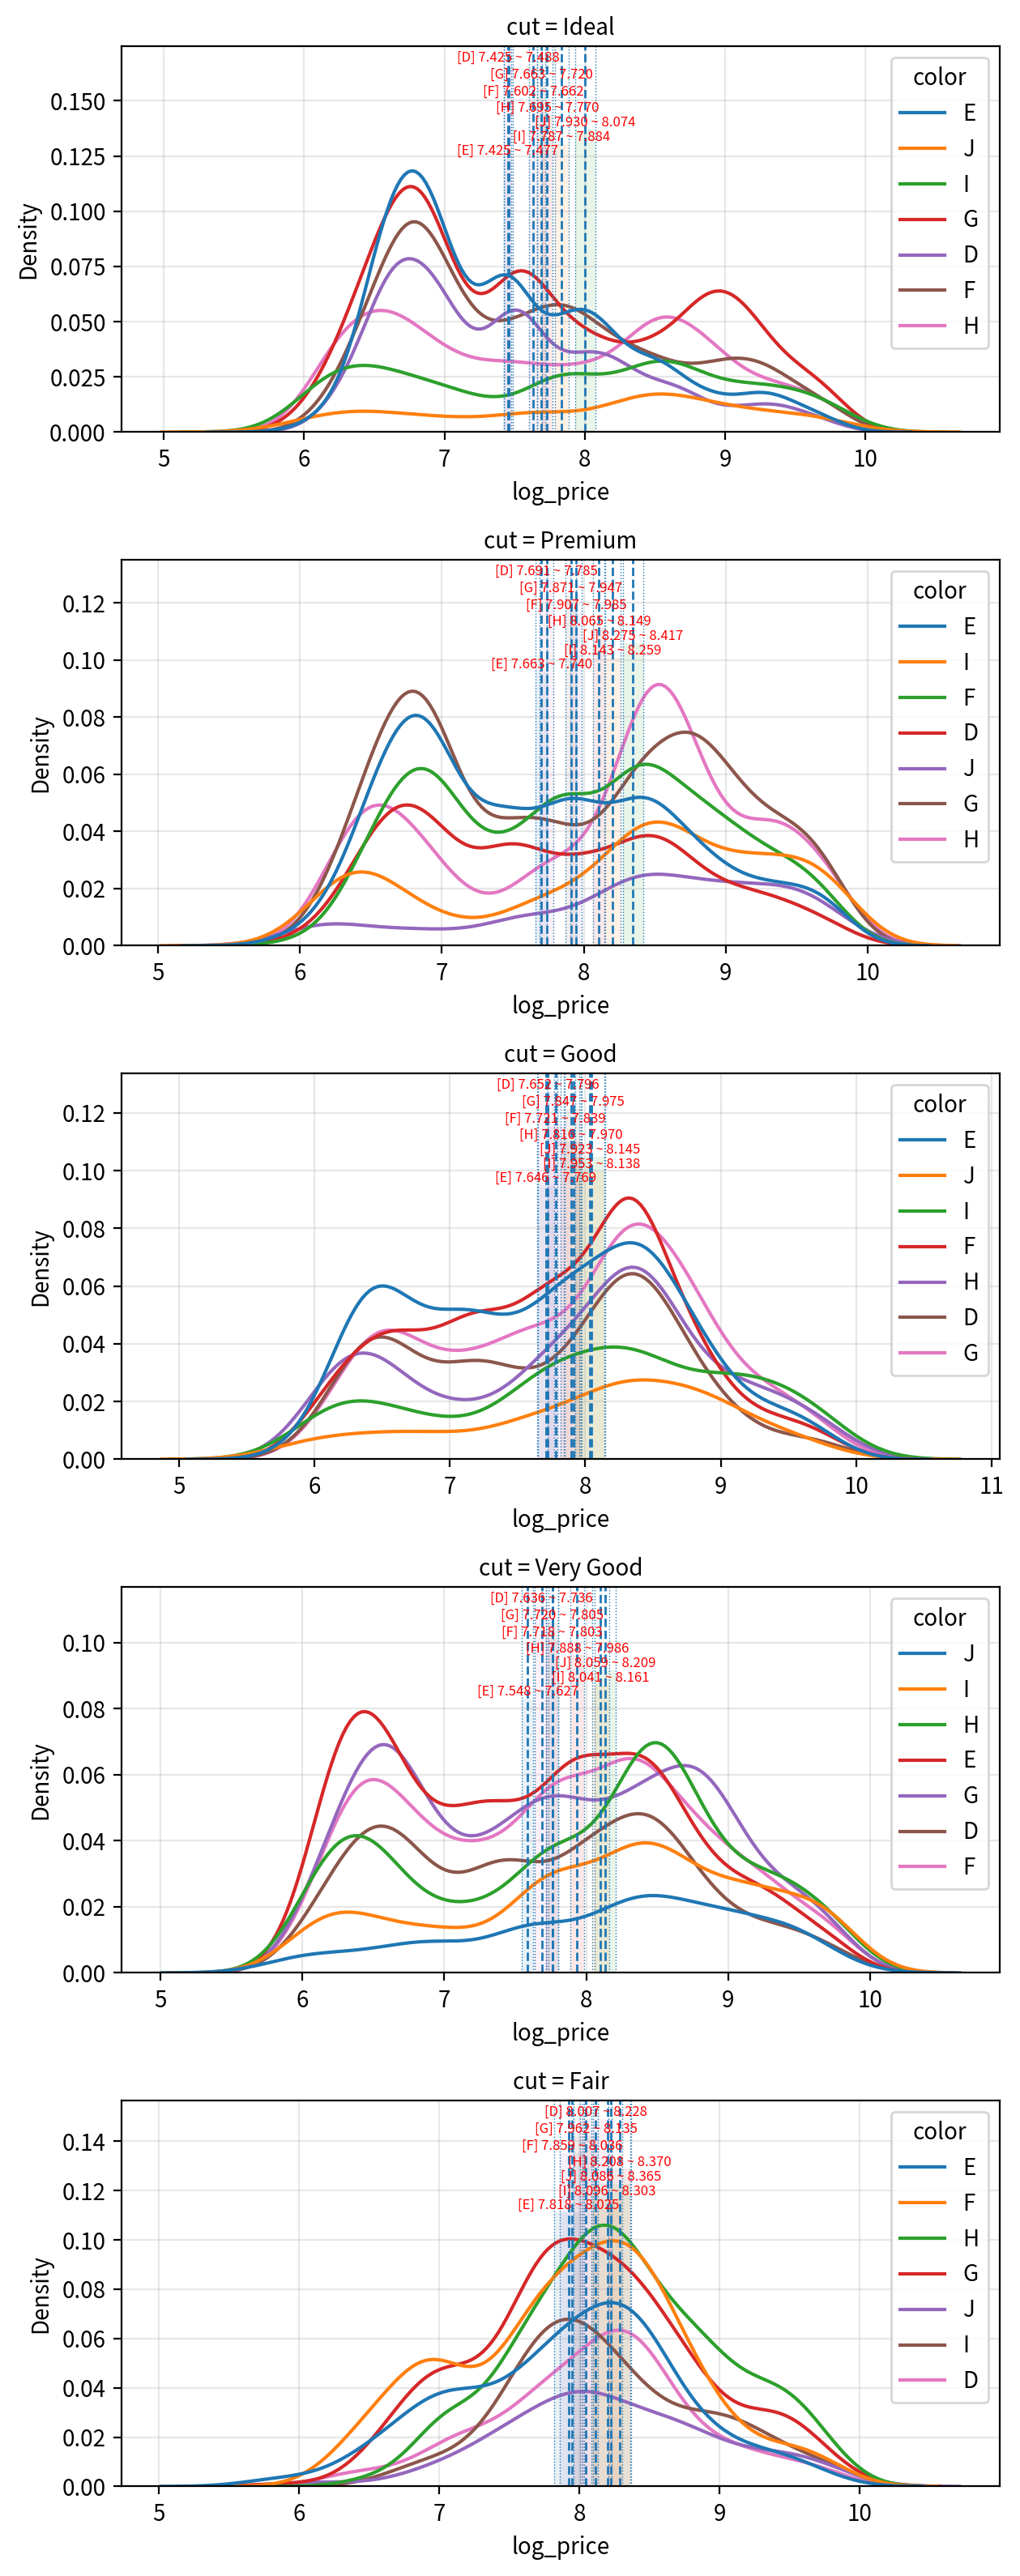

In [25]:
field = "log_price"
group_field = "cut"
hue_field = "color"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        # 표준오차가 0/NaN이면 스킵
        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [26]:
data = df7.copy()

xname = ["cut", "color"]
yname = "log_price"

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname].dropna()
        if len(filtered) == 0:
            continue

        equal_var_fields.append(filtered)

        s, p = normaltest(filtered)
        normalize = p > 0.05

        report.append(
            {
                "field": "{0}={1}, {2}={3}".format(xname[0], i, xname[1], j),
                "statistic": s,
                "p-value": p,
                "result": normalize,
            }
        )

        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields, center="median")

equal_var = p > 0.05

report.append({"field": n, "statistic": s, "p-value": p, "result": equal_var})

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
"cut=Ideal, color=E",310.449469,3.861485e-68,False
"cut=Ideal, color=I",2720.495708,0.000000e+00,False
"cut=Ideal, color=J",258.512577,7.323307e-57,False
"cut=Ideal, color=H",4463.144354,0.000000e+00,False
"cut=Ideal, color=F",526.215760,5.416261e-115,False
"cut=Ideal, color=G",2433.024869,0.000000e+00,False
"cut=Ideal, color=D",213.568495,4.209113e-47,False
"cut=Premium, color=E",358.024223,1.803133e-78,False
"cut=Premium, color=I",305.335780,4.979410e-67,False


In [27]:
xname = ["cut", "color"]
yname = "log_price"
data = df7[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,cut,898.699723,4.0,224.674931,228.100534,1.534256e-194,0.016650
1,color,1324.122097,6.0,220.687016,224.051816,1.005285e-283,0.024341
2,cut * color,95.012737,24.0,3.958864,4.019225,1.228913e-10,0.001787
3,Residual,53075.757557,53885.0,0.984982,NaN,NaN,NaN


→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * color 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [28]:
xname = ["cut", "color"]
yname = "log_price"

data = df7[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=1.53e-194) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499



[color]
- 주효과 유의 (p=1.01e-283) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,D,E,7.616603,7.579405,0.037199,0.014630,2.542700,14556.543791,1.442705e-01,0.040183
1,D,F,7.616603,7.762331,-0.145727,0.014993,-9.719835,14960.777520,0.000000e+00,-0.153289
2,D,G,7.616603,7.788974,-0.172371,0.014839,-11.615888,15427.251815,0.000000e+00,-0.173966
3,D,H,7.616603,7.917493,-0.300890,0.016209,-18.562688,15006.198965,0.000000e+00,-0.299767
4,D,I,7.616603,8.022663,-0.406060,0.018766,-21.638619,10552.203050,4.980460e-12,-0.402056
5,D,J,7.616603,8.145970,-0.529367,0.022593,-23.430733,4750.050236,3.315126e-13,-0.551216
6,E,F,7.579405,7.762331,-0.182926,0.013623,-13.427614,19234.992652,4.439005e-12,-0.193258
7,E,G,7.579405,7.788974,-0.209570,0.013454,-15.576802,21050.962689,1.998401e-14,-0.213516
8,E,H,7.579405,7.917493,-0.338089,0.014952,-22.612206,16582.336147,8.474887e-12,-0.341210
9,E,I,7.579405,8.022663,-0.443259,0.017690,-25.056439,9634.838335,0.000000e+00,-0.446179



[cut * color] 상호작용 효과
- 상호작용 유의 (p=1.23e-10) → 단순주효과 분석 필요


log_price(가격)에 대해 cut(컷 등급), color가 각각 어떤 영향을 미치는지와, 또 cut, clarity에 대한 두 요인이 함께 작용할 때를 검증하기 위해 이원 분산분석(2-way ANOVA)을 수행하였다.

color 사후검정(Games–Howell) 결과, 색 등급 간 평균(log_price) 차이는 대부분의 조합에서 유의했다(p≤0.05).
평균값(mean) 기준으로는 J(8.146) > I(8.023) > H(7.917) > G(7.789) > F(7.762) > D(7.617) > E(7.579) 순으로 나타난다.
따라서 color는 가격(log_price) 수준을 구분하는 데 의미가 있다.

In [29]:
df8 = df2[["cut", "clarity", "log_price"]].copy()
df8

,cut,clarity,log_price
0,Ideal,SI2,5.786897
1,Premium,SI1,5.786897
2,Good,VS1,5.789960
3,Premium,VS2,5.811141
4,Good,SI2,5.814131
...,...,...,...
53935,Ideal,SI1,7.921898
53936,Good,SI1,7.921898
53937,Very Good,SI1,7.921898
53938,Premium,SI2,7.921898


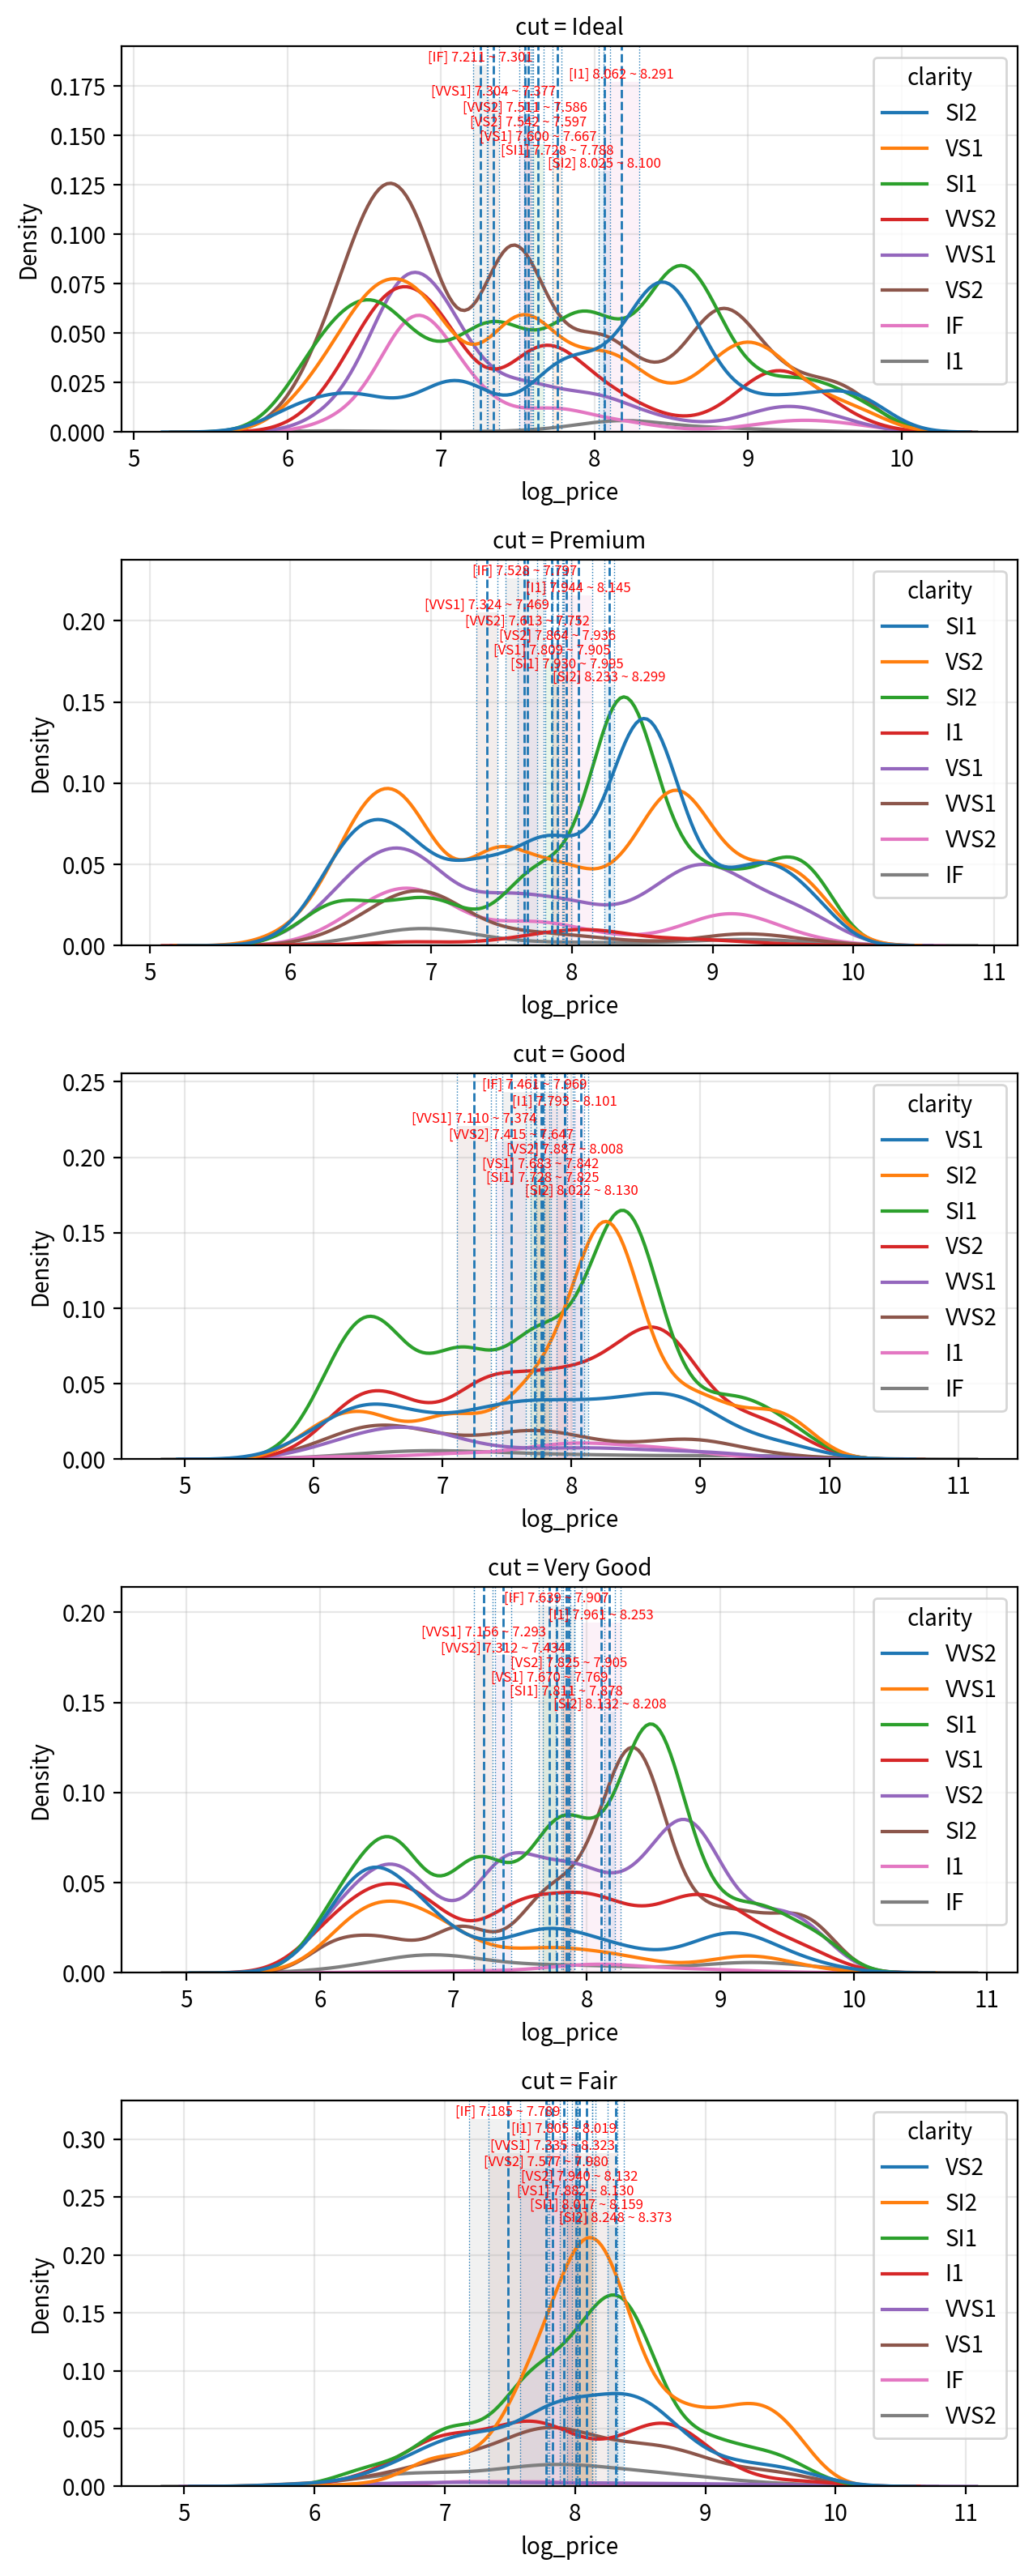

In [30]:
field = "log_price"
group_field = "cut"
hue_field = "clarity"


data = df2[[field, group_field, hue_field]].dropna().copy()

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count
cols = 1
width_px = 1280 * cols
height_px = 640 * rows
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]

    # KDE Plot
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        n = len(temp_sub[field])

        # 표본이 너무 적으면 신뢰구간 계산 불가 → 스킵
        if n < 2:
            continue

        clevel = 0.95
        dof = n - 1
        sp_mean = temp_sub[field].mean()
        sp_std = temp_sub[field].std(ddof=1)
        sp_std_error = sp_std / sqrt(n)

        if not (sp_std_error > 0):
            continue

        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

        # 신뢰구간 경계선
        ax[i].axvline(cmin, linestyle=":", linewidth=0.5)
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5)

        # 평균 및 신뢰구간 영역 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle="--", linewidth=1)

        # 텍스트
        ax[i].text(
            x=(cmax - cmin) / 2 + cmin,
            y=ymax,
            s="[%s] %0.3f ~ %0.3f" % (h, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"},
        )

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()

In [31]:
xname = ["cut", "clarity"]
yname = "log_price"
data = df8[xname + [yname]]

pg_anova = anova(data=data, dv=yname, between=xname, detailed=True)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row["Source"]
    p_val = row["p-unc"]

    if p_val <= 0.05:
        print(f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,cut,465.599616,4.0,116.399904,120.842091,7.710683e-103,0.008891
1,clarity,2296.175982,7.0,328.025140,340.543614,0.000000e+00,0.042368
2,cut * clarity,299.359587,28.0,10.691414,11.099432,2.564097e-49,0.005735
3,Residual,51899.356822,53880.0,0.963240,NaN,NaN,NaN


→ cut 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ cut * clarity 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [32]:
xname = ["cut", "clarity"]
yname = "log_price"

data = df8[xname + [yname]]

levels = {}  # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식 결과
for factor in xname:  # 요인을 하나씩 꺼냄
    level_count = data[factor].nunique()  # 요인의 수준 수 계산
    levels[factor] = level_count  # 딕셔너리에 저장

pvals = {}  # 빈 딕셔너리 만들기
# 예: {'water': 1.30e-20, 'sun': 2.01e-17, 'water * sun': 0.105}
for index, row in pg_anova.iterrows():  # 행을 하나씩 꺼냄
    source_name = row["Source"]  # 요인 이름
    p_value = row["p-unc"]  # 각 요인의 p-value
    pvals[source_name] = p_value  # 딕셔너리에 저장

# 주효과 사후검정
for factor in xname:
    print(f"\n[{factor}]")

    # 수준이 2개면 사후검정 필요 없음
    if levels[factor] == 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue

    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")

    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리
interaction_names = [src for src in pvals.keys() if "*" in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[cut]
- 주효과 유의 (p=7.71e-103) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Fair,Good,8.093026,7.842348,0.250678,0.023695,10.579464,3475.310280,3.799183e-13,0.268669
1,Fair,Ideal,8.093026,7.639297,0.453730,0.020264,22.390859,2033.505656,0.000000e+00,0.463793
2,Fair,Premium,8.093026,7.949996,0.143031,0.021022,6.803992,2345.633811,1.283564e-10,0.142233
3,Fair,Very Good,8.093026,7.798602,0.294424,0.021308,13.817769,2469.220433,0.000000e+00,0.291692
4,Good,Ideal,7.842348,7.639297,0.203051,0.015563,13.047300,7354.842443,0.000000e+00,0.205039
5,Good,Premium,7.842348,7.949996,-0.107647,0.016537,-6.509481,9001.061783,7.912575e-10,-0.105803
6,Good,Very Good,7.842348,7.798602,0.043746,0.016899,2.588657,9554.903552,7.249838e-02,0.042821
7,Ideal,Premium,7.639297,7.949996,-0.310699,0.011075,-28.053299,28558.962586,0.000000e+00,-0.308500
8,Ideal,Very Good,7.639297,7.798602,-0.159305,0.011609,-13.722405,24097.017625,0.000000e+00,-0.157926
9,Premium,Very Good,7.949996,7.798602,0.151394,0.012886,11.748769,25369.320809,1.272171e-11,0.146499



[clarity]
- 주효과 유의 (p=0) → 사후검정 수행
 · Games–Howell 사용 (등분산 불충족)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,I1,IF,8.027355,7.405190,0.622165,0.034921,17.816108,1685.065183,0.000000e+00,0.713736
1,I1,SI1,8.027355,7.847698,0.179657,0.028676,6.265097,891.560216,1.618550e-08,0.183797
2,I1,SI2,8.027355,8.166375,-0.139020,0.028966,-4.799401,927.616647,5.055519e-05,-0.153519
3,I1,VS1,8.027355,7.724646,0.302709,0.029687,10.196695,1021.725399,7.422951e-13,0.295533
4,I1,VS2,8.027355,7.762590,0.264765,0.028888,9.165196,918.010526,0.000000e+00,0.259862
5,I1,VVS1,8.027355,7.322330,0.705025,0.031076,22.687377,1209.480262,0.000000e+00,0.810581
6,I1,VVS2,8.027355,7.530843,0.496512,0.030897,16.070059,1188.903307,2.120526e-14,0.499883
7,IF,SI1,7.405190,7.847698,-0.442507,0.023387,-18.920961,2393.287329,7.117640e-13,-0.451114
8,IF,SI2,7.405190,8.166375,-0.761185,0.023742,-32.060497,2532.128234,0.000000e+00,-0.829466
9,IF,VS1,7.405190,7.724646,-0.319456,0.024616,-12.977379,2896.623483,0.000000e+00,-0.311861



[cut * clarity] 상호작용 효과
- 상호작용 유의 (p=2.56e-49) → 단순주효과 분석 필요


clarity 사후검정(Games–Howell) 결과, 명료도 등급 간 평균(log_price) 차이는 대부분의 조합에서 유의하였다.(p≤0.05).
평균값(mean) 기준으로는 SI2(8.166) > I1(8.027) > SI1(7.848) > VS2(7.763) > VS1(7.725) > VVS2(7.531) > IF(7.405) > VVS1(7.322) 순으로 나타난다.
따라서 [cut × clarity] 상호작용 효과는 유의하였다(p=2.56e-49).

## 📝미션 8. “가격과 가장 가까운 물리적 변수는?”

In [33]:
df8 = df2.filter(["log_price", "log_carat", "x", "y", "z", "depth", "table"])
df8

,log_price,log_carat,x,y,z,depth,table
0,5.786897,-1.469676,3.95,3.98,2.43,61.5,55.0
1,5.786897,-1.560648,3.89,3.84,2.31,59.8,61.0
2,5.789960,-1.469676,4.05,4.07,2.31,56.9,65.0
3,5.811141,-1.237874,4.20,4.23,2.63,62.4,58.0
4,5.814131,-1.171183,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...
53935,7.921898,-0.328504,5.75,5.76,3.50,60.8,57.0
53936,7.921898,-0.328504,5.69,5.75,3.61,63.1,55.0
53937,7.921898,-0.356675,5.66,5.68,3.56,62.8,60.0
53938,7.921898,-0.150823,6.15,6.12,3.74,61.0,58.0


In [34]:
skew_outlier = {}
for col in df8.columns:
    temp = df8[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        "original_skew": skew_original,
        "log_skew": skew_log,
        "outliers(|z|>3)": outlier_count,
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
log_price,0.115461,-0.226106,0.0
log_carat,0.096266,-0.144601,6.0
x,0.398348,-0.012942,35.0
y,2.462211,0.015552,27.0
z,1.585490,0.195391,36.0
depth,-0.081726,-2.177476,685.0
table,0.796799,0.159840,335.0


In [ ]:
rows = []

for a, b in combinations(df8.columns, 2):
    x = df8[a]
    y = df8[b]

    # [1] 선형성 확인 (Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue > 0.05

    # [2] 이상치 존재 여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, "outliers(|z|>3)"] > 0
    b_flag = skew_outlier_df.loc[b, "outliers(|z|>3)"] > 0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = "pearson"
        corr, pval = pearsonr(x, y)
    else:
        chosen = "spearman"
        corr, pval = spearmanr(x, y)

    # [4] 유의성 판단 (p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = "Very strong"
    elif abs_r >= 0.60:
        strength = "Strong"
    elif abs_r >= 0.40:
        strength = "Medium"
    elif abs_r >= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # [6] 행 추가
    rows.append(
        {
            "var_a": a,
            "var_b": b,
            "linearity": linearity_ok,
            "outlier_flag": outlier_flag,
            "chosen": chosen,
            "corr": corr,
            "pval": pval,
            "significant": significant,
            "strength": strength,
        }
    )

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,log_price,log_carat,False,True,spearman,0.962888,0.000000e+00,True,Very strong
1,log_price,x,False,True,spearman,0.963754,0.000000e+00,True,Very strong
2,log_price,y,False,True,spearman,0.963215,0.000000e+00,True,Very strong
3,log_price,z,False,True,spearman,0.958593,0.000000e+00,True,Very strong
4,log_price,depth,False,True,spearman,0.010013,2.006221e-02,True,Very weak
5,log_price,table,False,True,spearman,0.171797,0.000000e+00,True,Very weak
6,log_carat,x,False,True,spearman,0.996645,0.000000e+00,True,Very strong
7,log_carat,y,False,True,spearman,0.996033,0.000000e+00,True,Very strong
8,log_carat,z,False,True,spearman,0.994708,0.000000e+00,True,Very strong
9,log_carat,depth,True,True,spearman,0.030146,2.529887e-12,True,Very weak


In [36]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df["var_a"]).union(summary_df["var_b"]))
# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)
# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row["var_a"], row["var_b"], row["corr"]
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r  # 대칭
# 4) 대각선(diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

,depth,log_carat,log_price,table,x,y,z
depth,1.000000,0.030146,0.010013,-0.245098,-0.023214,-0.025186,0.103568
log_carat,0.030146,1.000000,0.962888,0.194941,0.996645,0.996033,0.994708
log_price,0.010013,0.962888,1.000000,0.171797,0.963754,0.963215,0.958593
table,-0.245098,0.194941,0.171797,1.000000,0.202294,0.195833,0.160294
x,-0.023214,0.996645,0.963754,0.202294,1.000000,0.997961,0.988378
y,-0.025186,0.996033,0.963215,0.195833,0.997961,1.000000,0.988141
z,0.103568,0.994708,0.958593,0.160294,0.988378,0.988141,1.000000


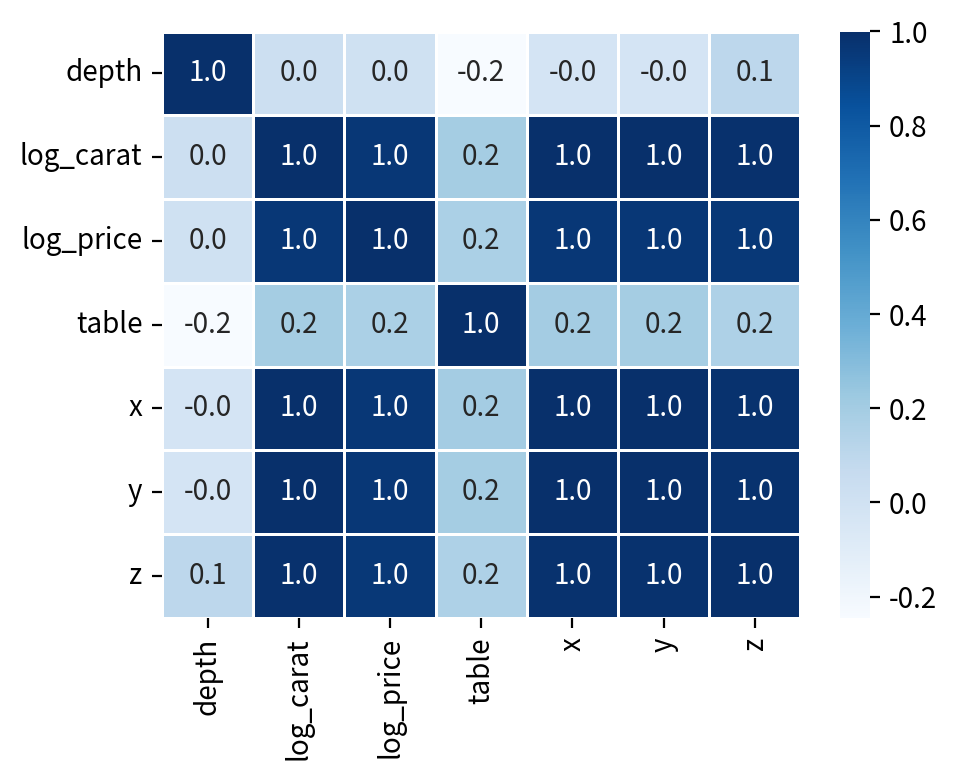

In [37]:
# 1) 그래프 초기화
width_px = 1000  # 그래프 가로 크기
height_px = 800  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="Blues",
    annot_kws={"size": 10},
)
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

가격 분포에 왜도랑 이상치가 존재하여 Pearson보다 Spearman(순위 기반)으로 해석하였다.
그 결과 price는 x가 가장 강하게 연결되어 있었고(r=0.96), y·carat·z도 거의 비슷하게 매우 높았다.
즉 다이아가 커질수록(무게/치수 증가) 가격도 같이 올라가는 경향이 뚜렷했고, depth나 table처럼 비율 변수는 가격과 관계가 약했다.

## 미션 9. “상관관계는 곧 원인일까?
상관이 높다는 것은 무엇을 의미하는가?
이 결과를 그대로 “원인”이라고 말해도 될까?

상관이 높다는 것은 두 변수가 함께 커지거나 작아지는 경향이 강하다는 뜻이다.
하지만 상관분석은 cut/color/clarity 같은 다른 요인을 통제하지 못하므로, 이 결과를 그대로 원인이라고 단정할 수는 없다.
또한 비선형 관계, 이상치 영향 때문에 상관이 더 작게 또는 크게 보일 수도 있다.
따라서 크기 변수들이 강하게 연결돼 있다는 관찰로 해석하고, 원인 판단은 추가 검증이 필요한 영역으로 남겨두는 것이 타당하다.

## 📝미션 10. “가격을 설명하는 회귀모형을 만들어보자

In [38]:
df10 = df2.filter(
    ["log_price", "log_carat", "depth", "table", "cut", "color", "clarity"]
).copy()
df10.head()

,log_price,log_carat,depth,table,cut,color,clarity
0,5.786897,-1.469676,61.5,55.0,Ideal,E,SI2
1,5.786897,-1.560648,59.8,61.0,Premium,E,SI1
2,5.789960,-1.469676,56.9,65.0,Good,E,VS1
3,5.811141,-1.237874,62.4,58.0,Premium,I,VS2
4,5.814131,-1.171183,63.3,58.0,Good,J,SI2


In [39]:
df10 = df2.filter(
    ["log_price", "log_carat", "depth", "table", "cut", "color", "clarity"]
).copy()

df10 = get_dummies(
    df10, columns=["cut", "color", "clarity"], dtype="int", drop_first=True
)
df10.head()

,log_price,log_carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,5.786897,-1.469676,61.5,55.0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,5.786897,-1.560648,59.8,61.0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,5.789960,-1.469676,56.9,65.0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,5.811141,-1.237874,62.4,58.0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5.814131,-1.171183,63.3,58.0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [40]:
yname = "log_price"

x = df10.drop(yname, axis=1)
y = df10[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl1 = fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.523e+05
Date:                Fri, 09 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:47:39   Log-Likelihood:                 31963.
No. Observations:               53920   AIC:                        -6.388e+04
Df Residuals:                   53899   BIC:                        -6.370e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.9362      0.043    183.219

log_price를 크기·품질·형태 구조로 설명하고 싶어서,

연속형 변수로 log_carat·depth·table을 포함하고, 품질 등급인 cut·color·clarity는 더미변수로 포함한 다중선형회귀모형을 적합했다.

모형은 유의했다. (F(20, 53899) = 1.523e+05, p ≤ 0.05; R-squared = 0.983)

기준범주(표에 더미가 없는 수준)는 cut=Fair, color=D, clarity=I1로 해석된다.

계수 기준으로 log_carat의 영향이 가장 크게 나왔다. (coef = 1.8838, p ≤ 0.05)
→ 해석: carat이 1% 커질 때, price는 약 1.88% 커지는 방향으로 관계가 잡혔다(다른 조건이 같다고 놓고).

품질 프리미엄은 cut에서 Fair 대비 Good 약 +8.2%, Very Good 약 +12.2%, Premium 약 +14.7%, Ideal 약 +17.1%로 추정됐다(모두 p ≤ 0.05).

color는 D 대비 E~J가 모두 음(-)의 계수로, 등급이 내려갈수록 가격이 단계적으로 감소하는 패턴을 보였다(예: J 약 -40.0%, p ≤ 0.05).

clarity는 I1 대비 모두 양(+)의 계수로 투명도 프리미엄이 나타났다(예: IF 약 +204.3%, p ≤ 0.05).

반면 depth는 p = 0.054로 5% 유의수준에서 유의하지 않았고, table도 p = 0.309로 유의하지 않았다.

## 📝미션 11. “이 회귀모형은 믿을 만할까?

In [41]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []

    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())

        def stars(p):
            return "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""

        # 한 변수에 대한 보고 정보 추가
        variables.append(
            {
                "종속변수": yname,  # 종속변수 이름 (외부에서 정의)
                "독립변수": name,  # 독립변수 이름
                "B": v[1].strip(),  # 비표준화 회귀계수(B)
                "표준오차": v[2].strip(),  # 계수 표준오차
                "Beta": float(fit.params[name])
                * (
                    data[name].std(ddof=1) / data[yname].std(ddof=1)
                ),  # 표준화 회귀계수(β)
                "t": "%s%s" % (v[3].strip(), stars(p)),  # t-통계량(+별표)
                "p-value": p,  # 계수 유의확률
                "공차": 1 / vif,  # 공차(Tolerance = 1/VIF)
                "vif": vif,  # 분산팽창계수
            }
        )

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for idx in [0, 2]:
        for item in tbl.tables[idx].data:
            n = len(item)
            for j in range(0, n, 2):
                key = item[j].strip()[:-1]
                value = item[j + 1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"𝑅({result_dict['R-squared']}), "
        f"𝑅^2({result_dict['Adj. R-squared']}), "
        f"𝐹({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    p_f = float(result_dict["Prob (F-statistic)"])
    sig_text = "유의하다" if p_f <= 0.05 else "유의하지 않다"
    p_sign = "≤" if p_f <= 0.05 else ">"

    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    )

    model_report = tpl % (
        rdf["종속변수"][0],
        ",".join(list(rdf["독립변수"])),
        sig_text,
        result_dict["Df Model"],
        result_dict["Df Residuals"],
        result_dict["F-statistic"],
        p_sign,
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        p_val = float(row["p-value"])
        p_sign_var = "≤" if p_val < 0.05 else ">"
        sig_word = "유의미한" if p_val < 0.05 else "유의하지 않은"

        variable_reports.append(
            s
            % (
                row["독립변수"],
                row["B"],
                p_sign_var,
                row["종속변수"],
                sig_word,
            )
        )

    return rdf, result_report, model_report, variable_reports

In [42]:
rdf, r, m, v = ols_report(tbl1, df10)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,log_carat,1.8838,0.001,1.085758,1659.875***,0.000,0.519562,1.924698
1,log_price,depth,-0.0009,0.000,-0.001287,-1.931,0.054,0.001927,518.884650
2,log_price,table,-0.0004,0.000,-0.000773,-1.017,0.309,0.001973,506.757575
3,log_price,cut_Good,0.0786,0.004,0.022259,19.757***,0.000,0.245392,4.075104
4,log_price,cut_Ideal,0.1582,0.004,0.076371,40.003***,0.000,0.069434,14.402188
5,log_price,cut_Premium,0.1368,0.004,0.058831,35.859***,0.000,0.103278,9.682591
6,log_price,cut_Very Good,0.1149,0.004,0.047233,30.137***,0.000,0.116887,8.555296
7,log_price,color_E,-0.0542,0.002,-0.020610,-25.600***,0.000,0.407464,2.454202
8,log_price,color_F,-0.0946,0.002,-0.035565,-44.141***,0.000,0.409466,2.442202
9,log_price,color_G,-0.1601,0.002,-0.064213,-76.348***,0.000,0.360732,2.772140


log_price에 대하여 log_carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(20,53899) = 1.523e+05, p ≤ 0.05).


In [43]:
df11 = df10.drop("depth", axis=1)
yname = "log_price"
x = df11.drop(yname, axis=1)
y = df11[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()
rdf, r, m, v = ols_report(tbl2, df11)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,log_carat,1.8838,0.001,1.085726,1660.329***,0.000,0.522292,1.914637
1,log_price,table,-7.939e-05,0.000,-0.000175,-0.252,0.801,0.011566,86.463431
2,log_price,cut_Good,0.0801,0.004,0.022702,20.581***,0.000,0.245608,4.071533
3,log_price,cut_Ideal,0.1610,0.004,0.077749,43.908***,0.000,0.071031,14.078305
4,log_price,cut_Premium,0.1394,0.004,0.059926,38.929***,0.000,0.103432,9.668217
5,log_price,cut_Very Good,0.1172,0.004,0.048153,32.251***,0.000,0.117056,8.542943
6,log_price,color_E,-0.0542,0.002,-0.020608,-25.597***,0.000,0.408596,2.447407
7,log_price,color_F,-0.0946,0.002,-0.035562,-44.136***,0.000,0.411441,2.430483
8,log_price,color_G,-0.1602,0.002,-0.064242,-76.393***,0.000,0.363652,2.749881
9,log_price,color_H,-0.2511,0.002,-0.089298,-112.824***,0.000,0.438819,2.278842


log_price에 대하여 log_carat,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(19,53900) = 1.604e+05, p ≤ 0.05).


In [44]:
df12 = df11.drop("table", axis=1)

yname = "log_price"
x = df12.drop(yname, axis=1)
y = df12[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl3 = fit.summary()
rdf, r, m, v = ols_report(tbl3, df12)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,log_carat,1.8837,0.001,1.085710,1668.528***,0.0,0.522840,1.912630
1,log_price,cut_Good,0.0801,0.004,0.022708,20.592***,0.0,0.284892,3.510103
2,log_price,cut_Ideal,0.1613,0.004,0.077862,45.442***,0.0,0.080128,12.480108
3,log_price,cut_Premium,0.1394,0.004,0.059934,38.942***,0.0,0.122948,8.133493
4,log_price,cut_Very Good,0.1172,0.004,0.048185,32.392***,0.0,0.135808,7.363356
5,log_price,color_E,-0.0542,0.002,-0.020610,-25.600***,0.0,0.429124,2.330329
6,log_price,color_F,-0.0945,0.002,-0.035560,-44.135***,0.0,0.433958,2.304371
7,log_price,color_G,-0.1602,0.002,-0.064237,-76.405***,0.0,0.383126,2.610105
8,log_price,color_H,-0.2511,0.002,-0.089295,-112.834***,0.0,0.462241,2.163375
9,log_price,color_I,-0.3725,0.002,-0.110417,-149.483***,0.0,0.555656,1.799675


log_price에 대하여 log_carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,53901) = 1.693e+05, p ≤ 0.05).


In [45]:
df13 = df12.drop("cut_Ideal", axis=1)

yname = "log_price"
x = df13.drop(yname, axis=1)
y = df13[yname]

x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl4 = fit.summary()
rdf, r, m, v = ols_report(tbl4, df13)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_price,log_carat,1.8801,0.001,1.083595,1638.477***,0.0,0.525991,1.901173
1,log_price,cut_Good,-0.0680,0.002,-0.019279,-31.428***,0.0,0.814216,1.228176
2,log_price,cut_Premium,-0.0091,0.001,-0.003893,-6.072***,0.0,0.611960,1.634093
3,log_price,cut_Very Good,-0.0322,0.002,-0.013230,-20.890***,0.0,0.651075,1.535922
4,log_price,color_E,-0.0545,0.002,-0.020730,-25.270***,0.0,0.433809,2.305163
5,log_price,color_F,-0.0959,0.002,-0.036086,-43.959***,0.0,0.438200,2.282063
6,log_price,color_G,-0.1609,0.002,-0.064506,-75.298***,0.0,0.387599,2.579984
7,log_price,color_H,-0.2522,0.002,-0.089714,-111.262***,0.0,0.467022,2.141229
8,log_price,color_I,-0.3727,0.003,-0.110458,-146.756***,0.0,0.560943,1.782711
9,log_price,color_J,-0.5126,0.003,-0.112269,-163.696***,0.0,0.698790,1.431046


log_price에 대하여 log_carat,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(17,53902) = 1.725e+05, p ≤ 0.05).


In [46]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 901.9192
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


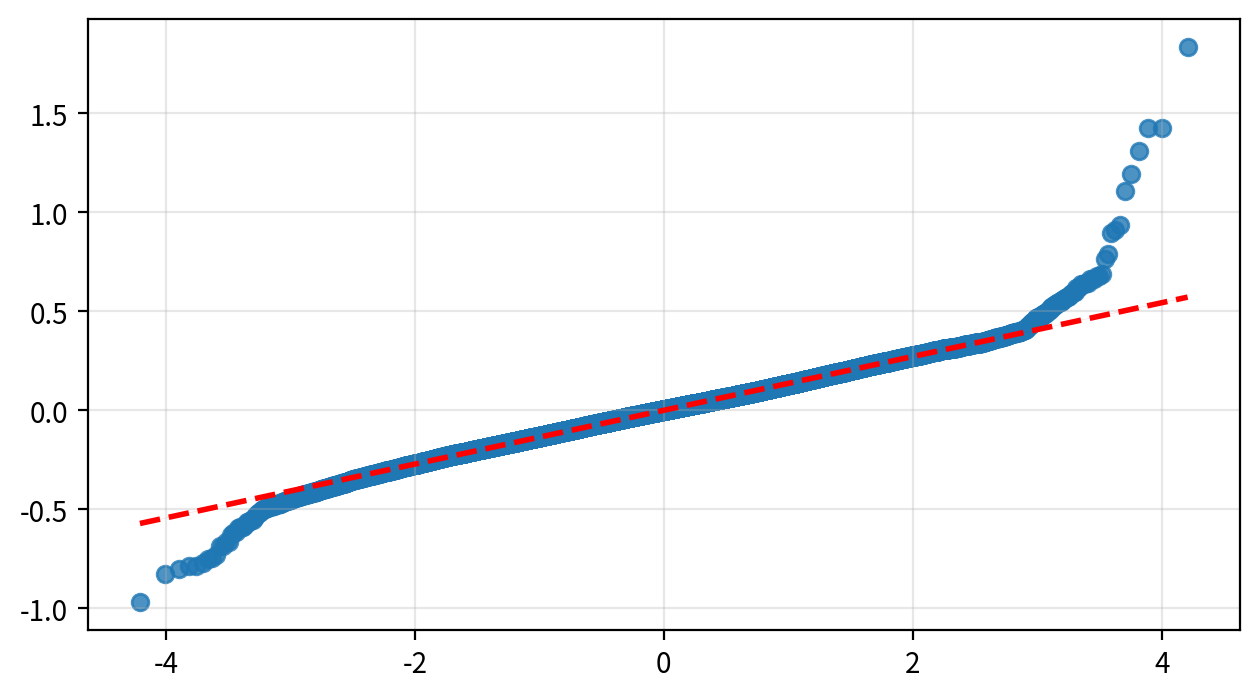

In [47]:
(x, y), _ = probplot(fit.resid)
# 1) 그래프 초기화
width_px = 1280  # 그래프 가로 크기
height_px = 720  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) regplot 그리기
sb.regplot(
    x=x, y=y, line_kws={"color": "red", "linestyle": "--", "linewidth": 2}  # 점선
)
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)  # 배경 격자 표시
# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

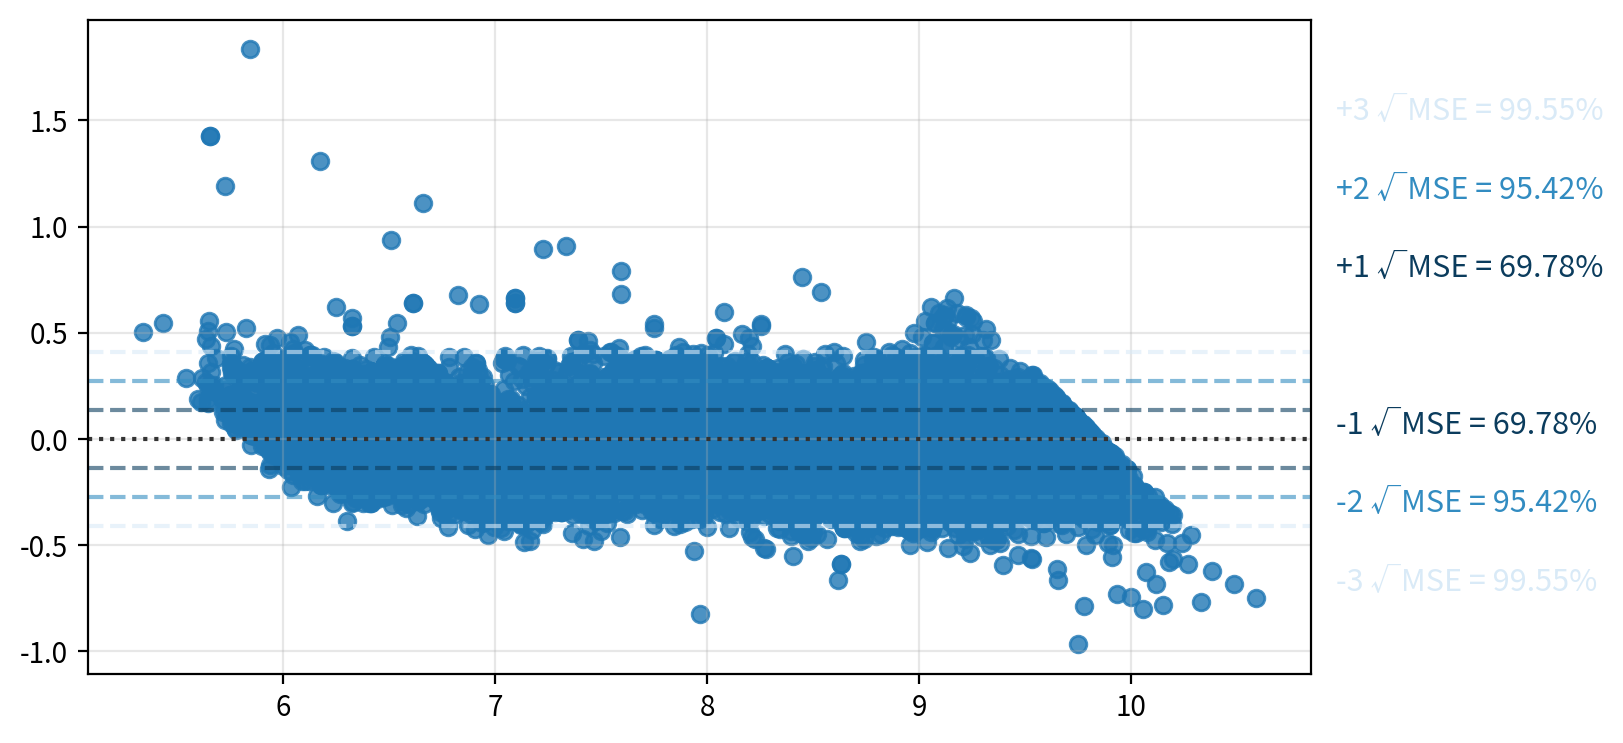

In [48]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid  # 잔차

r1 = r[(r > -mse_root) & (r < mse_root)].count() / r.count() * 100
r2 = r[(r > -2 * mse_root) & (r < 2 * mse_root)].count() / r.count() * 100
r3 = r[(r > -3 * mse_root) & (r < 3 * mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(
        x=1.02,
        y=0.5 + 0.12 * k,
        s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
    ax.text(
        x=1.02,
        y=0.5 - 0.12 * k,
        s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=11,
        color=c,
    )
# 5) 출력
plt.show()
plt.close()

In [49]:
if len(df13) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist="norm")
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5
print(
    "정규성 가정 위배 가능성이 있음 (5% 유의수준)"
    if violated
    else "정규성 가정 위배 근거 없음 (5%유의수준)"
)

Anderson-Darling statistic: 21.1106, 5% 임계값: 0.7870
정규성 가정 위배 가능성이 있음 (5% 유의수준)


In [50]:
# Breusch–Pagan Test
names = ["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=["value"])
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc["F p-value", "value"]
print(
    f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value ={p_bp:.3f}"
)
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 99.493, p-value =0.000
이분산성 존재(등분산 아님)


In [51]:
dw = durbin_watson(fit.resid)
if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 1.252
잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)


In [52]:
m

'log_price에 대하여 log_carat,cut_Good,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(17,53902) = 1.725e+05, p ≤ 0.05).'

In [53]:
print("\n".join(v))

log_carat의 회귀계수는 1.8801(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Good의 회귀계수는 -0.0680(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Premium의 회귀계수는 -0.0091(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
cut_Very Good의 회귀계수는 -0.0322(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_E의 회귀계수는 -0.0545(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_F의 회귀계수는 -0.0959(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_G의 회귀계수는 -0.1609(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_H의 회귀계수는 -0.2522(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_I의 회귀계수는 -0.3727(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
color_J의 회귀계수는 -0.5126(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_IF의 회귀계수는 1.1578(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI1의 회귀계수는 0.6305(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_SI2의 회귀계수는 0.4630(p ≤ 0.05)로, log_price에 대하여 유의미한 예측변인인 것으로 나타났다.
clarity_VS1의 회귀계수는 0.8522(p ≤ 0.05)로, log_price에 대하여 유의미한

(1) 잘 지켜진 점
회귀모형 전체가 유의했다(F 검정 p < 0.05).
log_carat, cut, color, clarity 관련 변수들의 p-value가 대부분 p < 0.05로 유의했다.
Durbin–Watson 값이 0에 아주 가깝지는 않았다(= 0.719보다 커졌다, 1.252).

(2) 아쉬운 점
정규성: Anderson–Darling 결과가 5% 기준에서 위배 가능성이 있다고 나왔다(통계량 21.1106 > 임계값 0.7870).
등분산: Breusch–Pagan에서 p < 0.05라서 이분산이 있다고 나왔다.
독립성: Durbin–Watson = 1.252로, 양(+)의 자기상관 가능성이 있다고 해석되었다(완전한 독립성이라고 보기 어려움).

(3) 개선 사항
잔차가 정규적이지 않다고 나왔으니(Anderson–Darling 위배) 이상치 처리 이후 모델을 다시 돌려볼 필요가 있다고 느꼇다.

## 미션 12. “같은 carat, 왜 가격은 다를까?

같은 carat이어도 가격이 다른 이유는, 회귀모형에서 cut·color·clarity 더미들이 모두 p ≤ 0.05로 유의했고 계수도 0이 아니게 추정되어 log_price를 추가로 올리거나(+) 내리는(-) 효과가 함께 반영되었기 때문이다. 즉 log_carat(무게)이 같더라도, cut과 clarity가 높은 수준일수록 log_price는 커지는 방향(양의 계수)으로 추정되었고, color는 기준 대비 E~J가 음의 계수로 나타나 log_price를 낮추는 방향으로 추정되었다. 
즉 carat은 크기(무게)를 나타내고, 가격은 크기뿐 아니라 깎임(cut), 색(color), 투명도(clarity) 같은 품질 등급 차이까지 함께 반영된다. 그래서 같은 크기(carat)라도 더 좋은 cut·clarity를 가진 경우 더 비싸게, 기준 대비 color 등급이 낮은 경우 더 저렴하게 추정되는 구조가 확인되었다.